#Imports

In [ ]:
!pip install torch
!pip install transformers
!pip install librosa
!pip install pandas

import librosa
import pandas as pd
import numpy as np
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torch
import os
import concurrent.futures
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch import nn
import soundfile as sf
import random




#Google Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Functions

In [ ]:
# Define the feature extraction function
def extract_features_wave2vec(audio_path, processor, model):
    y, sr = librosa.load(audio_path, sr=16000)  # Ensure 16kHz sampling rate
    input_values = processor(y, return_tensors="pt", sampling_rate=sr).input_values.to("cuda")
    with torch.no_grad():
        features = model(input_values).last_hidden_state.squeeze(0).cpu().numpy()  # Retain sequence dimension
    return features


def standardize_positions(positions, target_length):
    standardized_positions = []
    for pos in positions:
        if pos.shape[0] > target_length:
            pos = pos[:target_length, :]
        pad_width = [(0, max(0, target_length - pos.shape[0])), (0, 0)]
        pos_padded = np.pad(pos, pad_width, mode='constant')
        standardized_positions.append(pos_padded)
    return np.array(standardized_positions)

#Loading Files

In [ ]:

# Define base directory in Google Drive
base_dir = '/content/drive/MyDrive/Dissertation/TongueMocapData'

# Define subdirectory for audio files
audio_dir = os.path.join(base_dir, 'wav')

# Define subdirectory for positions
positions_dir = os.path.join(base_dir, 'ema/npy')

# Define subdirectory for indices
indices_dir = os.path.join(base_dir, 'index')

# Read indices from train.lst and test.lst
train_indices_file = os.path.join(indices_dir, 'train.lst')
test_indices_file = os.path.join(indices_dir, 'test.lst')

with open(train_indices_file, 'r') as f:
    train_indices = [line.strip() for line in f.readlines()]

with open(test_indices_file, 'r') as f:
    test_indices = [line.strip() for line in f.readlines()]

# Function to load corresponding audio file and position file for each index
def load_audio_and_positions(index):
    audio_file = os.path.join(audio_dir, index + '.wav')
    if os.path.exists(audio_file):
        print(f"Loading file: {index}")
        position_file = os.path.join(positions_dir, index + '.npy')
        return audio_file, np.load(position_file)
    return None, None

# Use concurrent.futures to load the audio files and positions in parallel for training and testing sets
def load_data(indices):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(load_audio_and_positions, indices))
    # Filter out None values
    audio_files = [result[0] for result in results if result[0] is not None]
    positions = [result[1] for result in results if result[1] is not None]
    return audio_files, positions

train_audio_files, train_positions = load_data(train_indices)
test_audio_files, test_positions = load_data(test_indices)

print(f"Loaded {len(train_audio_files)} training audio files and {len(train_positions)} training position files")
print(f"Loaded {len(test_audio_files)} test audio files and {len(test_positions)} test position files")


Loading file: 0015
Loading file: 0014
Loading file: 0009
Loading file: 0008
Loading file: 0013
Loading file: 0012
Loading file: 0016
Loading file: 0017
Loading file: 0018
Loading file: 0019
Loading file: 0020
Loading file: 0021
Loading file: 0023
Loading file: 0024
Loading file: 0027
Loading file: 0028
Loading file: 0032
Loading file: 0035
Loading file: 0036
Loading file: 0037
Loading file: 0038
Loading file: 0040
Loading file: 0041
Loading file: 0042
Loading file: 0043
Loading file: 0044
Loading file: 0047
Loading file: 0049
Loading file: 0050
Loading file: 0052
Loading file: 0053
Loading file: 0054
Loading file: 0055
Loading file: 0056
Loading file: 0057
Loading file: 0058
Loading file: 0059
Loading file: 0060
Loading file: 0062
Loading file: 0063
Loading file: 0064
Loading file: 0065
Loading file: 0069
Loading file: 0070
Loading file: 0071
Loading file: 0076
Loading file: 0078
Loading file: 0079
Loading file: 0080
Loading file: 0081
Loading file: 0083
Loading file: 0085
Loading file

#Data Augmentation


In [ ]:

# Function to augment audio file by changing the pitch
def augment_audio_pitch(audio_file, pitch_shift_steps):
    y, sr = librosa.load(audio_file, sr=None)
    y_shifted = librosa.effects.pitch_shift(y, sr=sr, n_steps=pitch_shift_steps)
    augmented_audio_file = audio_file.replace('.wav', f'_pitch_shifted_{pitch_shift_steps}.wav')
    sf.write(augmented_audio_file, y_shifted, sr)
    return augmented_audio_file

# Augment half of the loaded audio files and expand the data pool
def augment_and_expand_data_pool(audio_files, positions, pitch_shift_steps):
    augmented_audio_files = []
    augmented_positions = []

    num_files_to_augment = len(audio_files) // 3
    indices_to_augment = random.sample(range(len(audio_files)), num_files_to_augment)

    for i, (audio_file, position) in enumerate(zip(audio_files, positions)):
        print(f"Processing file {i+1}/{len(audio_files)}: {audio_file}")
        # Append original audio and position to the augmented lists
        augmented_audio_files.append(audio_file)
        augmented_positions.append(position)

        # Only augment and add half of the dataset
        if i in indices_to_augment:
            # Create augmented audio and append to the augmented lists
            augmented_audio_file = augment_audio_pitch(audio_file, pitch_shift_steps)
            augmented_audio_files.append(augmented_audio_file)
            augmented_positions.append(position)

    return augmented_audio_files, augmented_positions

# Define the pitch shift steps (positive for up, negative for down)
pitch_shift_steps = 1.5  # For example, shifting pitch up by 2 steps

# Augment and expand training and testing datasets
augmented_train_audio_files, augmented_train_positions = augment_and_expand_data_pool(train_audio_files, train_positions, pitch_shift_steps)
augmented_test_audio_files, augmented_test_positions = augment_and_expand_data_pool(test_audio_files, test_positions, pitch_shift_steps)

print(f"Original training audio files: {len(train_audio_files)}")
print(f"Augmented training audio files: {len(augmented_train_audio_files)}")
print(f"Original test audio files: {len(test_audio_files)}")
print(f"Augmented test audio files: {len(augmented_test_audio_files)}")

train_audio_files = augmented_train_audio_files
test_audio_files = augmented_test_audio_files
train_positions = augmented_train_positions
test_positions = augmented_test_positions




Processing file 1/1519: /content/drive/MyDrive/Dissertation/TongueMocapData/wav/0008.wav
Processing file 2/1519: /content/drive/MyDrive/Dissertation/TongueMocapData/wav/0009.wav
Processing file 3/1519: /content/drive/MyDrive/Dissertation/TongueMocapData/wav/0012.wav
Processing file 4/1519: /content/drive/MyDrive/Dissertation/TongueMocapData/wav/0013.wav
Processing file 5/1519: /content/drive/MyDrive/Dissertation/TongueMocapData/wav/0014.wav
Processing file 6/1519: /content/drive/MyDrive/Dissertation/TongueMocapData/wav/0015.wav
Processing file 7/1519: /content/drive/MyDrive/Dissertation/TongueMocapData/wav/0016.wav
Processing file 8/1519: /content/drive/MyDrive/Dissertation/TongueMocapData/wav/0017.wav
Processing file 9/1519: /content/drive/MyDrive/Dissertation/TongueMocapData/wav/0018.wav
Processing file 10/1519: /content/drive/MyDrive/Dissertation/TongueMocapData/wav/0019.wav
Processing file 11/1519: /content/drive/MyDrive/Dissertation/TongueMocapData/wav/0020.wav
Processing file 12/

#Feature Extraction

In [ ]:
# Load Wave2Vec model and processor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(device)

# Extract features
# Add progress printing within the list comprehension
def extract_features(audio_files):
    features = []
    for i, f in enumerate(audio_files):
        print(f"Processing file {i+1}/{len(audio_files)}: {f}")
        features.append(extract_features_wave2vec(f, processor, model))
    return features

train_features = extract_features(train_audio_files)
test_features = extract_features(test_audio_files)

# Determine the maximum sequence length for padding
max_length = max(max(len(f) for f in train_features), max(len(f) for f in test_features))
max_length_pos = max(max(len(f) for f in train_positions), max(len(f) for f in test_positions))
# Pad/truncate features to max_length
def pad_features(features, max_length):
    padded_features = [f[:max_length] if f.shape[0] > max_length else np.pad(f, ((0, max_length - f.shape[0]), (0, 0)), mode='constant') for f in features]
    return np.array(padded_features)

train_features = pad_features(train_features, max_length)
test_features = pad_features(test_features, max_length)

# Ensure positions have the same sequence length
#def standardize_positions(positions, max_length):
 #   standardized_positions = [p[:max_length] if p.shape[0] > max_length else np.pad(p, ((0, max_length - p.shape[0]), (0, 0)), mode='constant') for p in positions]
  #  return standardized_positions

train_positions = standardize_positions(train_positions, max_length_pos)
test_positions = standardize_positions(test_positions, max_length_pos)

train_positions = np.array(train_positions)
test_positions = np.array(test_positions)

print(train_features.shape)  # Expected: (num_train_samples, max_length, feature_dim)
print(train_positions.shape)  # Expected: (num_train_samples, max_length, 30)
print(test_features.shape)  # Expected: (num_test_samples, max_length, feature_dim)
print(test_positions.shape)  # Expected: (num_test_samples, max_length, 30)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing file 1/1519: /content/drive/MyDrive/Dissertation/TongueMocapData/wav/0008.wav
Processing file 2/1519: /content/drive/MyDrive/Dissertation/TongueMocapData/wav/0009.wav
Processing file 3/1519: /content/drive/MyDrive/Dissertation/TongueMocapData/wav/0012.wav
Processing file 4/1519: /content/drive/MyDrive/Dissertation/TongueMocapData/wav/0013.wav
Processing file 5/1519: /content/drive/MyDrive/Dissertation/TongueMocapData/wav/0014.wav
Processing file 6/1519: /content/drive/MyDrive/Dissertation/TongueMocapData/wav/0015.wav
Processing file 7/1519: /content/drive/MyDrive/Dissertation/TongueMocapData/wav/0016.wav
Processing file 8/1519: /content/drive/MyDrive/Dissertation/TongueMocapData/wav/0017.wav
Processing file 9/1519: /content/drive/MyDrive/Dissertation/TongueMocapData/wav/0018.wav
Processing file 10/1519: /content/drive/MyDrive/Dissertation/TongueMocapData/wav/0019.wav
Processing file 11/1519: /content/drive/MyDrive/Dissertation/TongueMocapData/wav/0020.wav
Processing file 12/

#Train-Validation-Test Split

In [ ]:

# Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_features, train_positions, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Create DataLoader
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(test_features, dtype=torch.float32), torch.tensor(test_positions, dtype=torch.float32))

# Define batch size
batch_size = 8

# Create DataLoader with specified batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check the sizes of the datasets
print(f"Training set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")

Training set size: 1139
Validation set size: 380
Test set size: 381


#Model Definitions

Consider General adversarial network


##Model 1

In [ ]:
# Define the LSTM-based neural network model
class TongueMovementModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(TongueMovementModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out)
        return output

input_dim = train_features.shape[2]
hidden_dim = 128
output_dim = train_positions.shape[2]
num_layers = 3
print(input_dim)
print(train_positions.shape[2])
print(output_dim)

model = TongueMovementModel(input_dim, hidden_dim, output_dim, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

768
30
30


##Model 2

In [ ]:
class TongueMovementModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, bidirectional=False, dropout=0.2):
        super(TongueMovementModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, bidirectional=bidirectional, dropout=dropout)
        direction_factor = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_dim * direction_factor, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)
        output = self.fc(lstm_out)
        return output

input_dim = train_features.shape[2]
hidden_dim = 128
output_dim = train_positions.shape[2]
num_layers = 3
bidirectional = True
dropout = 0.3


print("Input Dim:", input_dim)
print("Output Dim:", output_dim)

model = TongueMovementModel(input_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)


Input Dim: 768
Output Dim: 30


##Model 3

In [ ]:
class TongueMovementTransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, nhead=8, dropout=0.2):
        super(TongueMovementTransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = x.permute(1, 0, 2)  # Transformer expects input of shape (seq_len, batch_size, hidden_dim)
        transformer_out = self.transformer_encoder(x)
        transformer_out = transformer_out.permute(1, 0, 2)  # Convert back to (batch_size, seq_len, hidden_dim)
        output = self.fc(transformer_out)
        return output

# Define model parameters
input_dim = train_features.shape[2]
hidden_dim = 128
output_dim = train_positions.shape[2]
num_layers = 3
nhead = 8
dropout = 0.3

print("Input Dim:", input_dim)
print("Output Dim:", output_dim)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TongueMovementTransformerModel(input_dim, hidden_dim, output_dim, num_layers, nhead, dropout).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

Input Dim: 768
Output Dim: 30


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")



##Model 4

In [ ]:
class TongueMovementGRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, bidirectional=False, dropout=0.2):
        super(TongueMovementGRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers,
                          batch_first=True, bidirectional=bidirectional, dropout=dropout)
        direction_factor = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_dim * direction_factor, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        gru_out = self.dropout(gru_out)
        output = self.fc(gru_out)
        return output

# Define model parameters
input_dim = train_features.shape[2]
hidden_dim = 256
output_dim = train_positions.shape[2]
num_layers = 4
bidirectional = True
dropout = 0.3

print("Input Dim:", input_dim)
print("Output Dim:", output_dim)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TongueMovementGRUModel(input_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout).to(device)
criterion = nn.MSELoss()
#criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99)
#optimizer = optim.Adagrad(model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.3)


Input Dim: 768
Output Dim: 30


#Training

## MSE Training

In [ ]:
num_epochs = 1000
patience = 5
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for val_i`nputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            val_running_loss += val_loss.item()

    avg_val_loss = val_running_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

    #scheduler.step(avg_val_loss)
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save the model's state_dict
        torch.save(model.state_dict(), '/content/drive/MyDrive/Dissertation/model_state_dict.pth')

    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break




Epoch 1/1000, Train Loss: 27.858574761842426, Val Loss: 5.13754815235734
Epoch 2/1000, Train Loss: 5.0195724273982805, Val Loss: 4.448721341788769
Epoch 3/1000, Train Loss: 4.184612655639649, Val Loss: 3.5039655081927776
Epoch 4/1000, Train Loss: 3.3869738528603, Val Loss: 2.6444607730954885
Epoch 5/1000, Train Loss: 2.679535068336286, Val Loss: 2.1290782932192087
Epoch 6/1000, Train Loss: 2.3071624743311028, Val Loss: 1.8566049076616764
Epoch 7/1000, Train Loss: 2.05421615023362, Val Loss: 1.73040053807199
Epoch 8/1000, Train Loss: 1.882710023302781, Val Loss: 1.6270872056484222
Epoch 9/1000, Train Loss: 1.7537236263877467, Val Loss: 1.5905460715293884
Epoch 10/1000, Train Loss: 1.6250979624296489, Val Loss: 1.5792014505714178
Epoch 11/1000, Train Loss: 1.5327672763874656, Val Loss: 1.4994233381003141
Epoch 12/1000, Train Loss: 1.442928405811912, Val Loss: 1.4692348539829254
Epoch 13/1000, Train Loss: 1.3674000664761192, Val Loss: 1.5267880149185658
Epoch 14/1000, Train Loss: 1.296400

## L2 Training

In [ ]:
num_epochs = 1000
patience = 5
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        # Calculate L2 norm loss (Euclidean distance)
        l2_norm_loss = torch.norm(outputs - targets, p=2)

        l2_norm_loss.backward()
        optimizer.step()
        running_loss += l2_norm_loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = model(val_inputs)

            # Calculate L2 norm loss for validation
            val_l2_norm_loss = torch.norm(val_outputs - val_targets, p=2)

            val_running_loss += val_l2_norm_loss.item()

    avg_val_loss = val_running_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

    # Early stopping and model saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save the model's state_dict
        torch.save(model.state_dict(), '/content/drive/MyDrive/Dissertation/model_state_dict.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break


Epoch 1/1000, Train Loss: 1432.5394756610576, Val Loss: 681.0034236907959
Epoch 2/1000, Train Loss: 661.2709832891718, Val Loss: 585.0962880452474
Epoch 3/1000, Train Loss: 588.3517010028546, Val Loss: 512.3933588663737
Epoch 4/1000, Train Loss: 517.3352490405102, Val Loss: 449.5389696756999
Epoch 5/1000, Train Loss: 471.3966380299388, Val Loss: 417.20726585388184
Epoch 6/1000, Train Loss: 444.1041054892373, Val Loss: 408.18338712056476
Epoch 7/1000, Train Loss: 424.2281195367133, Val Loss: 395.0127188364665
Epoch 8/1000, Train Loss: 409.52944444776415, Val Loss: 391.3912359873454
Epoch 9/1000, Train Loss: 392.65229583953646, Val Loss: 376.46346219380695
Epoch 10/1000, Train Loss: 380.3215688425344, Val Loss: 377.18823369344074
Epoch 11/1000, Train Loss: 370.0430299985659, Val Loss: 375.8132495880127
Epoch 12/1000, Train Loss: 361.84751273201897, Val Loss: 372.78403345743817
Epoch 13/1000, Train Loss: 355.3381294303841, Val Loss: 368.7113978068034
Epoch 14/1000, Train Loss: 344.5709906

## Temporal L2 Norm

In [ ]:
num_epochs = 1000
patience = 5
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        # Calculate L2 norm loss (Euclidean distance) for each time step
        l2_norms_per_timestep = torch.norm(outputs - targets, p=2, dim=2)

        # Calculate the temporal mean L2 norm loss for the sequence
        temporal_mean_l2_loss = l2_norms_per_timestep.mean(dim=1).mean()  # Mean across time steps and batch

        # Backward pass
        temporal_mean_l2_loss.backward()
        optimizer.step()

        running_loss += temporal_mean_l2_loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = model(val_inputs)

            # Calculate L2 norm loss for validation
            val_l2_norms_per_timestep = torch.norm(val_outputs - val_targets, p=2, dim=2)
            val_temporal_mean_l2_loss = val_l2_norms_per_timestep.mean(dim=1).mean()  # Mean across time steps and batch

            val_running_loss += val_temporal_mean_l2_loss.item()

    avg_val_loss = val_running_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

    # Early stopping and model saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save the model's state_dict
        torch.save(model.state_dict(), '/content/drive/MyDrive/Dissertation/model_state_dict.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break


Epoch 1/1000, Train Loss: 20.118697679959812, Val Loss: 8.662471771240234
Epoch 2/1000, Train Loss: 8.336841956718818, Val Loss: 7.132809023062388
Epoch 3/1000, Train Loss: 7.451318284014722, Val Loss: 6.36745011806488
Epoch 4/1000, Train Loss: 6.597758196450614, Val Loss: 5.683833817640941
Epoch 5/1000, Train Loss: 6.040250438076633, Val Loss: 5.209186315536499
Epoch 6/1000, Train Loss: 5.6627660464573575, Val Loss: 4.912160098552704
Epoch 7/1000, Train Loss: 5.384865530720957, Val Loss: 4.76320602496465
Epoch 8/1000, Train Loss: 5.180416697388762, Val Loss: 4.71507312854131
Epoch 9/1000, Train Loss: 4.971011458576976, Val Loss: 4.634313712517421
Epoch 10/1000, Train Loss: 4.810269827609296, Val Loss: 4.599188024799029
Epoch 11/1000, Train Loss: 4.656420904439646, Val Loss: 4.458726420998573
Epoch 12/1000, Train Loss: 4.5297262118412895, Val Loss: 4.50744333366553
Epoch 13/1000, Train Loss: 4.436324756462257, Val Loss: 4.413586949308713
Epoch 14/1000, Train Loss: 4.332838098485987, Va

#Loading Model for Testing

##Current Model

In [ ]:
# Load the model's state_dict
model.load_state_dict(torch.load('/content/drive/MyDrive/Dissertation/model_state_dict.pth'))
model.eval()  # Set the model to evaluation mode
print("Model's state_dict has been loaded successfully.")

Model's state_dict has been loaded successfully.


## Best MSE model

In [ ]:
# Load the model's state_dict
model.load_state_dict(torch.load('/content/drive/MyDrive/Dissertation/MSEbest_model_state_dict.pth'))
model.eval()  # Set the model to evaluation mode
print("Model's state_dict has been loaded successfully.")

Model's state_dict has been loaded successfully.


## L2 Best Model


In [ ]:
# Load the model's state_dict
model.load_state_dict(torch.load('/content/drive/MyDrive/Dissertation/L2Bestmodel_state_dict.pth'))
model.eval()  # Set the model to evaluation mode
print("Model's state_dict has been loaded successfully.")

<ipython-input-8-8e35a1204006>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/Dissertation/L2Bestmodel_state_dict.

Model's state_dict has been loaded successfully.


#Model Evaluation

##MSE Eval

In [ ]:
# Function to evaluate the model
def evaluate_model(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    return avg_test_loss

# Evaluate the model
test_loss = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss}")


Test Loss: 1.4728233516216278


## L2 Norm Eval

In [ ]:
# Function to evaluate the model using L2 norm
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            # Calculate L2 norm loss (Euclidean distance)
            l2_norm_loss = torch.norm(outputs - targets, p=2)
            test_loss += l2_norm_loss.item()

    avg_test_loss = test_loss / len(test_loader)
    return avg_test_loss

# Evaluate the model
test_loss = evaluate_model(model, test_loader, device)
print(f"Test Loss: {test_loss}")

# Load the model's state_dict
model.load_state_dict(torch.load('/content/drive/MyDrive/Dissertation/model_state_dict.pth'))
model.eval()  # Set the model to evaluation mode
print("Model's state_dict has been loaded successfully.")


Test Loss: 377.8612861633301
Model's state_dict has been loaded successfully.


## Temporal L2 norm


In [ ]:
# Function to calculate temporal mean L2-norm error across the test split
def evaluate_temporal_mean_l2_norm(model, test_loader, device, output_dim):
    model.eval()  # Set the model to evaluation mode
    temporal_mean_l2 = 0.0
    total_sequences = 0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            # Calculate L2 norm for each time step
            l2_norms_per_timestep = torch.norm(outputs - targets, p=2, dim=2)

            # Calculate the temporal mean L2 norm for each sequence
            temporal_mean_l2_per_sequence = l2_norms_per_timestep.mean(dim=1)  # Mean across time steps

            # Sum these values across all sequences
            temporal_mean_l2 += temporal_mean_l2_per_sequence.sum().item()
            total_sequences += temporal_mean_l2_per_sequence.size(0)  # Count the number of sequences

    # Calculate the average temporal mean L2 norm across all sequences
    avg_temporal_mean_l2_norm = temporal_mean_l2 / total_sequences
    return avg_temporal_mean_l2_norm

# Evaluate the model
output_dim = 30  # Define the output_dim based on your model
test_loss = evaluate_temporal_mean_l2_norm(model, test_loader, device, output_dim)
print(f"Test Loss (Temporal Mean L2 Norm): {test_loss}")


Test Loss (Temporal Mean L2 Norm): 4.354598152981655


#Comparison to Baseline Loss

In [ ]:
print("Target Value Range:")
print(f"Min: {np.min(y_test)}, Max: {np.max(y_test)}")
baseline_prediction = np.mean(y_train, axis=0)
baseline_loss = np.mean((y_test - baseline_prediction) ** 2)
print(f"Baseline Loss: {baseline_loss}")

Target Value Range:
Min: -70.20339705509645, Max: 23.922952118269382
Baseline Loss: 25.879144234081394


#Visualisation

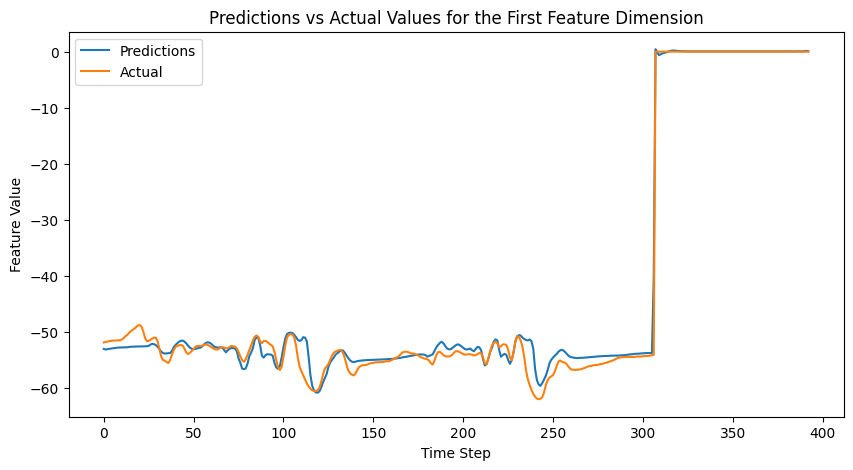

In [ ]:
import matplotlib.pyplot as plt
# Define the predict function
def predict(model, inputs, device):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        inputs = inputs.to(device)
        outputs = model(inputs)
    return outputs.cpu().numpy()  # Return the predictions as a NumPy array

# Get a batch of test inputs and targets
test_inputs, test_targets = next(iter(test_loader))

# Make predictions for the test inputs
predictions = predict(model, test_inputs, device)

# Plot predictions vs actual values for the first feature dimension
plt.figure(figsize=(10, 5))
# file number, time step, Feature
plt.plot(predictions[0, :, 0], label='Predictions')
plt.plot(test_targets.numpy()[0, :, 0], label='Actual')
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Feature Value')
plt.title('Predictions vs Actual Values for the First Feature Dimension')
plt.show()



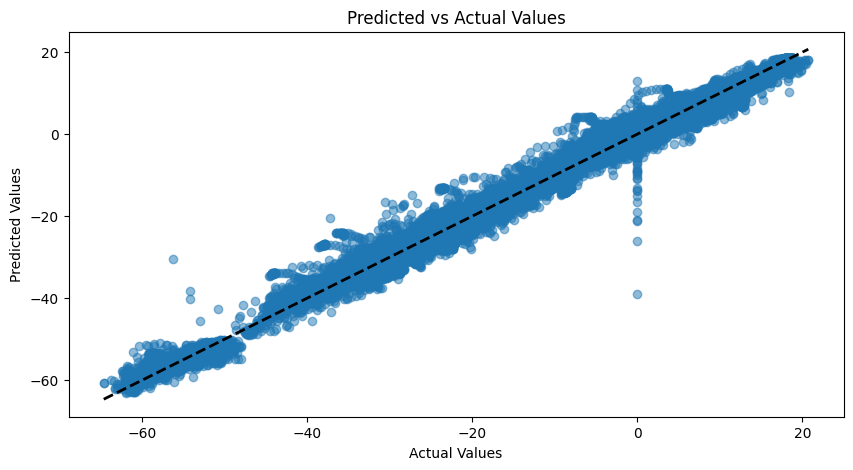

In [ ]:
predictions = predict(model, test_inputs, device)
actual_values = test_targets.numpy()
predictions_flat = predictions.flatten()
actual_values_flat = actual_values.flatten()
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(actual_values_flat, predictions_flat, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.plot([actual_values_flat.min(), actual_values_flat.max()],
         [actual_values_flat.min(), actual_values_flat.max()], 'k--', lw=2)
plt.show()




Mean Absolute Error: 0.7953530550003052
Average Euclidean Distance: 0.20727710723876952


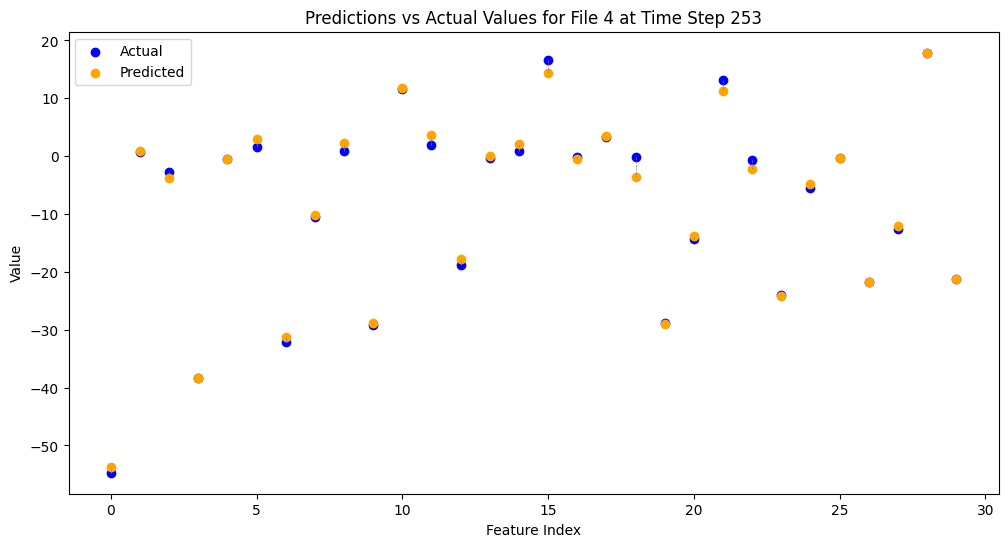

In [ ]:
predictions = predict(model, test_inputs, device)
actual_values = test_targets.numpy()
file_index = 3  # Index of the file to plot
time_step = 253   # Specific time step to plot

pred_values = predictions[file_index, time_step, :]
actual_values = actual_values[file_index, time_step, :]

# Calculate Mean Absolute Error (MAE)
abs_differences = np.abs(pred_values - actual_values)
mae = np.mean(abs_differences)
print(f"Mean Absolute Error: {mae}")

# Calculate Average Euclidean Distance
euclidean_distance = np.sqrt(np.sum((pred_values - actual_values) ** 2))
average_distance = euclidean_distance / len(pred_values)
print(f"Average Euclidean Distance: {average_distance}")

import matplotlib.pyplot as plt
import numpy as np

# Number of features
num_features = pred_values.shape[0]

# Indices for the features
feature_indices = np.arange(num_features)

plt.figure(figsize=(12, 6))

# Scatter plot for actual and predicted values
plt.scatter(feature_indices, actual_values, color='blue', label='Actual')
plt.scatter(feature_indices, pred_values, color='orange', label='Predicted')

# Draw lines between actual and predicted values
for i in range(num_features):
    plt.plot([feature_indices[i], feature_indices[i]], [actual_values[i], pred_values[i]], color='gray', linestyle='--', linewidth=0.5)

plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.title(f'Predictions vs Actual Values for File {file_index + 1} at Time Step {time_step}')
plt.legend()
plt.show()







In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

# Flatten the arrays for metric calculation
flat_predictions = predictions.flatten()
flat_targets = test_targets.numpy().flatten()

mae = mean_absolute_error(flat_targets, flat_predictions)
r2 = r2_score(flat_targets, flat_predictions)

print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")


Mean Absolute Error: 0.6627184748649597
R-squared: 0.9917478013099527


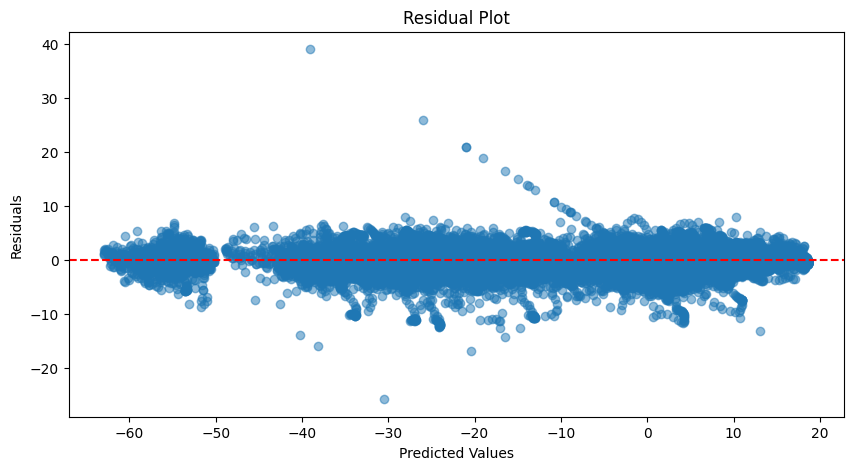

In [ ]:
residuals = actual_values_flat - predictions_flat
plt.figure(figsize=(10, 5))
plt.scatter(predictions_flat, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


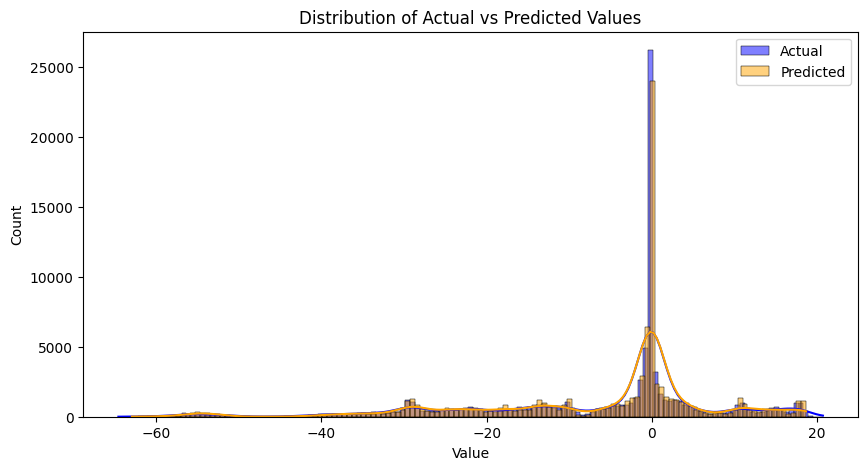

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(actual_values_flat, color='blue', label='Actual', kde=True)
sns.histplot(predictions_flat, color='orange', label='Predicted', kde=True)
plt.legend()
plt.xlabel('Value')
plt.title('Distribution of Actual vs Predicted Values')
plt.show()


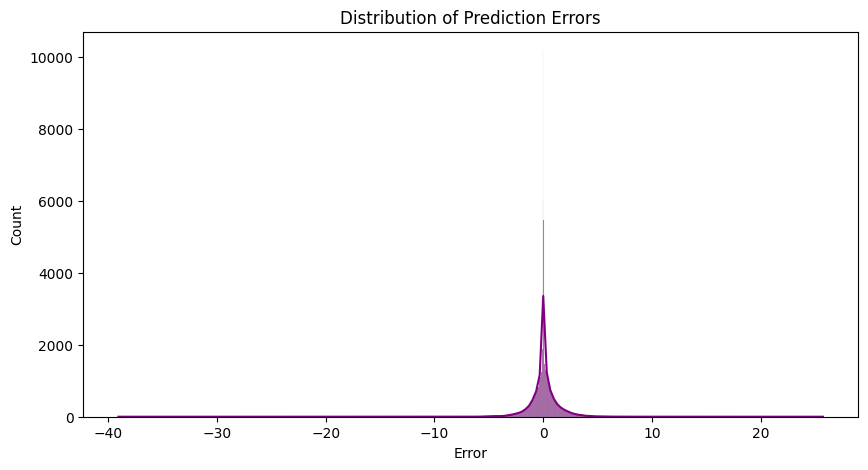

In [ ]:
errors = predictions_flat - actual_values_flat
plt.figure(figsize=(10, 5))
sns.histplot(errors, kde=True, color='purple')
plt.xlabel('Error')
plt.title('Distribution of Prediction Errors')
plt.show()
